# NBA Game Prediction: Logistic Regression (Modelling Teams)
Written by Nicholas Cannon 22241579

In [302]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay
)

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'teams')
STATE = 42
team_ids = os.listdir(DATA_DIR)
NON_FEATURE_COLS = ['GAME_ID', 'DATE', 'SEASON', 'TEAM', 'OPPONENT']

In [590]:
def run_metrics(y_pred, y_true):    
    print('F1 =', f1_score(y_true, y_pred, average='weighted'))
    print('Accuracy =', accuracy_score(y_true, y_pred))
    print('n games =', len(y_pred))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred),
        display_labels=['Lose', 'Win']
    ).plot(cmap=plt.cm.Blues, ax=ax1)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)).plot(ax=ax2)
    
    prec, recall, _ = precision_recall_curve(y_pred, y_true)
    PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
    
    plt.show()


def preprocess_team(team_id, drop_adv=False, season_avg=False, window=5, drop_percentages=False, 
                    split_data=True, test_size=0.2):
    """
    Preprocess the given teams data set with configurable options.
    """
    df = pd.read_csv(os.path.join(DATA_DIR, team_id))

    # shift label up 1 game
    df['WON'] = df['WON'].shift(periods=-1)
    df.dropna(inplace=True)

    # get a copy of the columns not run through averaging
    non_avgs = df[[*NON_FEATURE_COLS, 'HOME']].copy()

    # separate features and labels (and drop non feature cols)
    X = df.drop([*NON_FEATURE_COLS, 'WON', 'HOME'], axis=1)
    y = df['WON']
    
    # drop derived cols
    if drop_percentages:
        X = X.drop(['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'RBC'], axis=1)
    else:
        X = X.drop(['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'ORBC', 'DRBC',], axis=1)

    # drop the advanced stats
    if drop_adv:
        X = X.drop(['PLUS_MIN', 'TM_TOV_PCT', 'OFF_RATING', 'DEF_RATING', 
                    'TS_PCT', 'PACE', 'PTS_OFF_TO', 'PTS_2ND_CHANCE',
                    'PTS_FB', 'PTS_PAINT', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS',
                    'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA'], axis=1, errors='ignore')

    # Run averaging and add the non_avg cols after
    if season_avg:
        X = X.expanding().mean()
        X = pd.concat([non_avgs, X], axis=1)
    else:
        X = X.rolling(window).mean()
        X = pd.concat([non_avgs, X], axis=1)

        X.dropna(inplace=True) # drop first few games
        y = y[window-1:]
    
    if split_data:
        return train_test_split(X, y, test_size=test_size, random_state=STATE)
    else:
        return X, y

# Model definition

In [581]:
def train_model(**preprocess_args):
    # Build data set from team sets
    X_full, y_full = pd.DataFrame(), pd.DataFrame()
    for team_id in team_ids:
        X_team, y_team = preprocess_team(team_id, split_data=False, **preprocess_args)

        X_full = pd.concat([X_full, X_team], ignore_index=True)
        y_full = pd.concat([y_full, y_team], ignore_index=True)
        
    # hold out 2018 season for final testing
    test_full = X_full[X_full['SEASON'] == 2018]
    
    # remove the hold out data
    X_full = X_full.iloc[:-test_full.shape[0], :]
    y_full = y_full.iloc[:-test_full.shape[0], 0]
    
    # drop the non feature cols
    X_full.drop(NON_FEATURE_COLS, inplace=True, axis=1)

    # train / test split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=STATE)
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=STATE))
    ])
    params = {
        'clf__C': [1.0, 0.8, 0.5],
        'clf__penalty': ['l1', 'l2']
    }

    clf = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    # local model results summary
    print('**Local Model Results**')
    print('-'*30)
    print('F1 = ', f1_score(y_test, y_pred))
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('Best Parameters = ', clf.best_params_)
    print('-'*30)

    return clf.best_estimator_, test_full


def test_model(clf, features):
    y_pred, y_true = [], []
    game_order = {}
    
    # Read and process the labels from the individual teams data,
    # the labels used in the training data are shifted up by 1 game.
    # This gives access to the ground truth for each game in the 2018 season.
    labels = pd.DataFrame()
    for team_id in team_ids:
        df = pd.read_csv(os.path.join(DATA_DIR, team_id))
        
        # filter by 2018 season
        df = df[df['SEASON'] == 2018]
        
        # create list of game_ids so we can fetch the previous game features
        game_order[team_id[:-4]] = df['GAME_ID'].tolist()
        
        # convert back to home / away perspectives
        df['H_ID'] = df.apply(lambda r: r['TEAM'] if r['HOME'] == 1 else r['OPPONENT'], axis=1)
        df['A_ID'] = df.apply(lambda r: r['TEAM'] if r['HOME'] == 0 else r['OPPONENT'], axis=1)
        df['HOME_WIN'] = df.apply(lambda r: 1 - (r['WON'] ^ r['HOME']), axis=1)
        
        df = df[['GAME_ID', 'DATE', 'H_ID', 'A_ID', 'HOME_WIN']]
        
        labels = pd.concat([labels, df], ignore_index=True)

    # each game will have two entries, one for each team so drop the dups
    labels.drop_duplicates(inplace=True)
    
    # drop any games that aren't in the feature set
    labels = labels[labels['GAME_ID'].isin(features['GAME_ID'].unique())]
    
    # make predictions on all feature games
    for _, game in labels.iterrows():
        # find the index of this game
        h_game_idx = game_order[str(game['H_ID'])].index(game['GAME_ID'])
        a_game_idx = game_order[str(game['A_ID'])].index(game['GAME_ID'])
        
        # skip first game of season
        if h_game_idx == 0 or a_game_idx == 0:
            continue
        
        # pull out home / away team features for their previous game
        h_data = features[
            (features['TEAM'] == game['H_ID']) & 
            (features['GAME_ID'] == game_order[str(game['H_ID'])][h_game_idx - 1])
        ]
        a_data = features[
            (features['TEAM'] == game['A_ID']) & 
            (features['GAME_ID'] == game_order[str(game['A_ID'])][a_game_idx - 1])
        ]
        
        # clean features
        h_data = h_data.iloc[0].drop(NON_FEATURE_COLS).values
        a_data = a_data.iloc[0].drop(NON_FEATURE_COLS).values

        # get prediction vals
        prob_h_win = clf.predict([h_data])
        prob_a_win = clf.predict([a_data])
        
        # record prediction results and label
        y_pred.append(1 if prob_h_win >= prob_a_win else 0)
        y_true.append(game['HOME_WIN'])

    return y_pred, y_true

## Experiment 1: 5 Game Moving Average

In [582]:
clf_1, test_features_1 = train_model(season_avg=False, window=5)

**Local Model Results**
------------------------------
F1 =  0.6011281224818695
Accuracy =  0.5935960591133005
Best Parameters =  {'clf__C': 1.0, 'clf__penalty': 'l1'}
------------------------------


F1 = 0.6175566066293955
Accuracy = 0.6405990016638935
n games = 1202


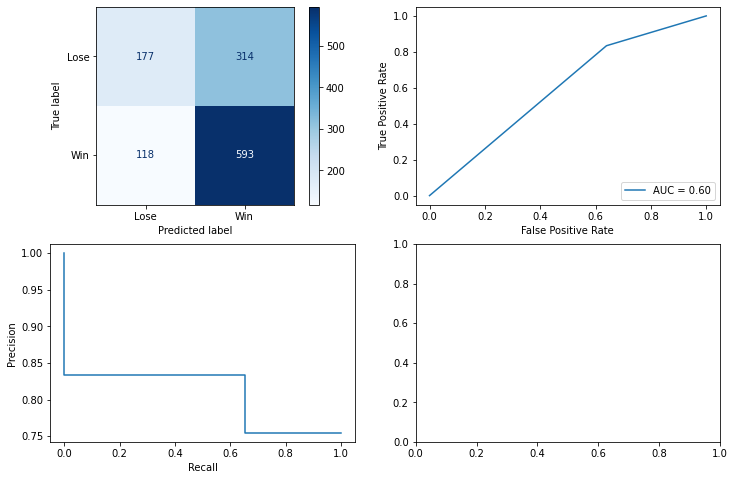

In [591]:
y_pred_1, y_true_1 = test_model(clf_1, test_features_1)
run_metrics(y_pred_1, y_true_1)

## Experiment 2: Season Average

In [584]:
clf_2, test_features_2 = train_model(season_avg=True)

**Local Model Results**
------------------------------
F1 =  0.601909506019095
Accuracy =  0.6101626016260162
Best Parameters =  {'clf__C': 0.5, 'clf__penalty': 'l1'}
------------------------------


F1 = 0.616939310479634
Accuracy = 0.6364392678868552
n games = 1202


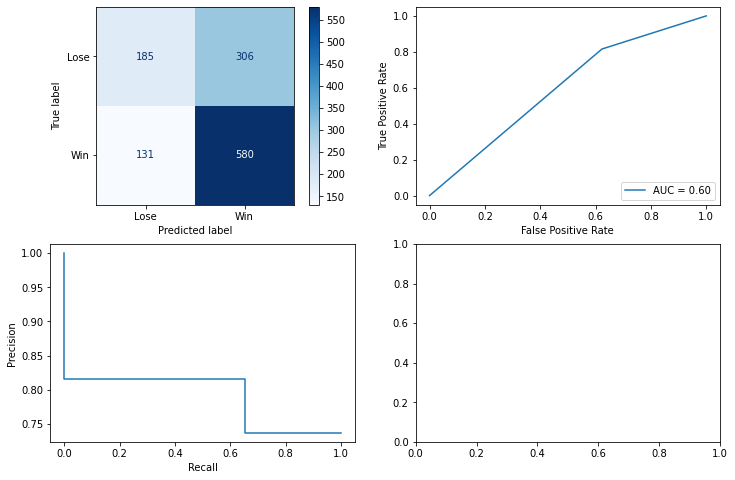

In [592]:
y_pred_2, y_true_2 = test_model(clf_2, test_features_2)
run_metrics(y_pred_2, y_true_2)

## Experiment 3: 5 Game Moving Average, drop percentages

In [586]:
clf_3, test_features_3 = train_model(season_avg=False, drop_percentages=True)

**Local Model Results**
------------------------------
F1 =  0.5995165189363417
Accuracy =  0.5919540229885057
Best Parameters =  {'clf__C': 1.0, 'clf__penalty': 'l1'}
------------------------------


F1 = 0.6093966573259614
Accuracy = 0.6331114808652246
n games = 1202


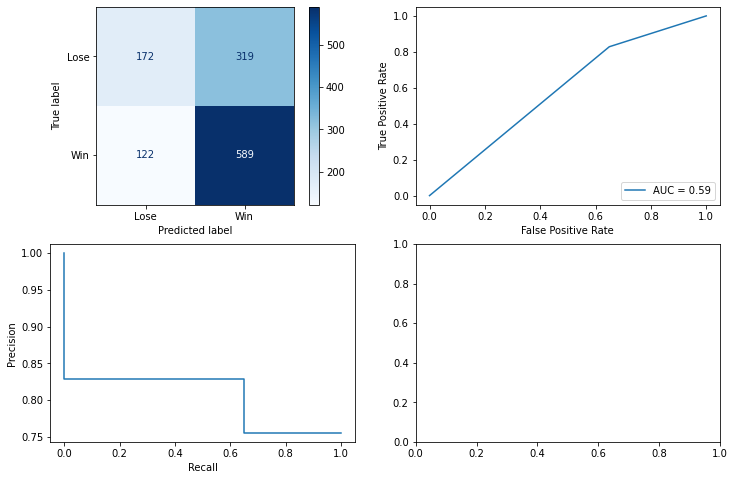

In [593]:
y_pred_3, y_true_3 = test_model(clf_3, test_features_3)
run_metrics(y_pred_3, y_true_3)

## Experiment 4: Removing Advanced Stats

In [588]:
clf_4, test_features_4 = train_model(season_avg=True, drop_adv=True)

**Local Model Results**
------------------------------
F1 =  0.6083061889250814
Accuracy =  0.6089430894308943
Best Parameters =  {'clf__C': 0.5, 'clf__penalty': 'l1'}
------------------------------


F1 = 0.5955354766399631
Accuracy = 0.6164725457570716
n games = 1202


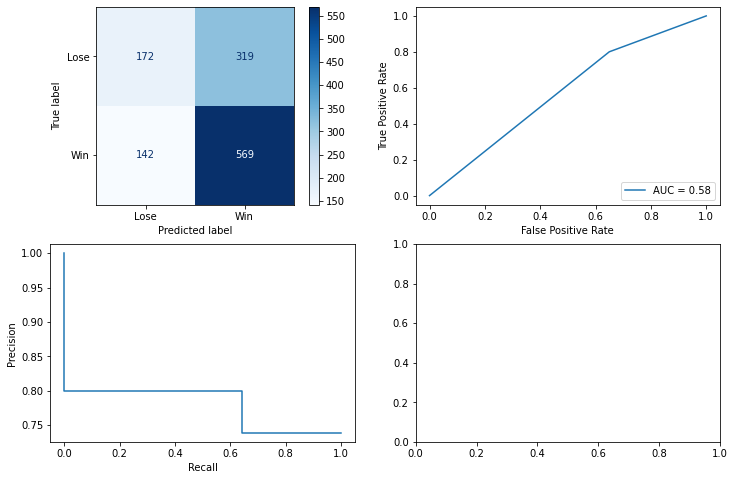

In [594]:
y_pred_4, y_true_4 = test_model(clf_4, test_features_4)
run_metrics(y_pred_4, y_true_4)